# RNN - Many-to-many
> In this post, We will cover the many-to-many RNN model, which can be used for Part of Speech (POS) tagging and Named Entity Recognition (NER).

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Deep_Learning, Tensorflow-Keras]
- image: images/many-to-many-pos.png

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

print('Tensorflow: {}'.format(tf.__version__))

plt.rcParams['figure.figsize'] = (16, 10)
plt.rc('font', size=15)

Tensorflow: 2.3.1


## What is "Many-to-many"?

Previously, we covered 3 kinds of RNN model, one-to-one, many-to-one, and many-to-one with stacked model. Especially on many-to-one model, it gets an sequence data as an input, and generates the single output. So it can be used for classification, and previous example shows simple implementation of many-to-one model for word/sequence classification.

Then, what is **many-to-many** model?

![many-to-many](image/many-to-many.png) {% fn 1 %}

The concept is same as before. In many-to-one model, to generate the output, the final input must be entered into model. Unlike this, many-to-many model generates the output whenever each input is read. That is, many-to-many model can understand the feature of each token in input sequence.

![many-to-many-pos](image/many-to-many-pos.png)

One possible example is [**Part-of-Speech**](https://en.wikipedia.org/wiki/Part_of_speech) tagging, POS for short. POS is a category of words (or lexical items) that have similar grammatical properties. Common POS type are noun, verb, adjective, adverb, pronoun, etc. {% fn 2 %}. So POS tagging is automatically tagged POS of each token. Of course, it can manually handle with rule-based model, but many-to-many model is appropriate for doing this.

For example, we have a sentence.
$$ \text{tensorflow is very easy} $$

In order to do POS tagging, word tokenization is processed on that sentence. After that, we can get

$$ [\text{'tensorflow', 'is', 'very', 'easy'}] $$

Then POS will be tagged on each token like this,

$$[\text{'noun', 'verb', 'adverb', 'adjective'}]$$

If the many-to-many model is well-trained, whole process will be happened well.

Unlike many-to-one model, loss measure is also different in many-to-many model. In many-to-one model, it can measure the loss by comparing the prediction value($\hat{y}$) and actual value($y$). But in many-to-many model, each output node can measure the loss. There are many losses, so common ways to use it for training is by averaging whole losses. This kind of loss is called **sequence loss**. After that, specific optimizer (SGD or Adam) tries to minimize the loss with backpropagation.

One thing we need to consider is handling padding tokens('<pad>'). As you saw from previous post, padding tokens are for formalize the various length of each sentence, it has no meaning. So it is required to remove (or "masking") padding tokens before training.

## Example - Part of Speech Tagging

### Prepraring Dataset

In this section, we will implement the simple many-to-many model for POS tagging. Of course, there are two types of training data, sentence, and POS of that sentence. (Assume that we already tokenize each sentence.)

In [2]:
sentences = [['I', 'feel', 'hungry'],
             ['tensorflow', 'is', 'very', 'difficult'],
             ['tensorflow', 'is', 'a', 'framework', 'for', 'deep', 'learning'],
             ['tensorflow', 'is', 'very', 'fast', 'changing']]

pos = [['pronoun', 'verb', 'adjective'], 
       ['noun', 'verb', 'adverb', 'adjective'],
       ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun'],
       ['noun', 'verb', 'adverb', 'adjective', 'verb']]

Same as previous example, we can build token dictionary. And additionally, we need to build POS dictionary.

In [3]:
word_list =['<pad>'] + sorted(set(sum(sentences, []))) 
word2idx = {word:idx for idx, word in enumerate(word_list)}
idx2word = {idx:word for idx, word in enumerate(word_list)}

print(word_list)
print(word2idx)
print(idx2word)

['<pad>', 'I', 'a', 'changing', 'deep', 'difficult', 'fast', 'feel', 'for', 'framework', 'hungry', 'is', 'learning', 'tensorflow', 'very']
{'<pad>': 0, 'I': 1, 'a': 2, 'changing': 3, 'deep': 4, 'difficult': 5, 'fast': 6, 'feel': 7, 'for': 8, 'framework': 9, 'hungry': 10, 'is': 11, 'learning': 12, 'tensorflow': 13, 'very': 14}
{0: '<pad>', 1: 'I', 2: 'a', 3: 'changing', 4: 'deep', 5: 'difficult', 6: 'fast', 7: 'feel', 8: 'for', 9: 'framework', 10: 'hungry', 11: 'is', 12: 'learning', 13: 'tensorflow', 14: 'very'}


In [4]:
pos_list = ['<pad>'] + sorted(set(sum(pos, [])))
pos2idx = {pos:idx for idx, pos in enumerate(pos_list)}
idx2pos = {idx:pos for idx, pos in enumerate(pos_list)}

print(pos_list)
print(pos2idx)
print(idx2pos)

['<pad>', 'adjective', 'adverb', 'determiner', 'noun', 'preposition', 'pronoun', 'verb']
{'<pad>': 0, 'adjective': 1, 'adverb': 2, 'determiner': 3, 'noun': 4, 'preposition': 5, 'pronoun': 6, 'verb': 7}
{0: '<pad>', 1: 'adjective', 2: 'adverb', 3: 'determiner', 4: 'noun', 5: 'preposition', 6: 'pronoun', 7: 'verb'}


We build the dictionary for dataset. Based on this, we can convert from sentence to numerical vector.

In [5]:
X = list(map(lambda sentence: [word2idx.get(token) for token in sentence], sentences))
y = list(map(lambda sentence: [pos2idx.get(token) for token in sentence], pos))

print(X)
print(y)

[[1, 7, 10], [13, 11, 14, 5], [13, 11, 2, 9, 8, 4, 12], [13, 11, 14, 6, 3]]
[[6, 7, 1], [4, 7, 2, 1], [4, 7, 3, 4, 5, 1, 4], [4, 7, 2, 1, 7]]


As you can see, the length of each sentence is various. We can fix the the length with `pad_sequences`. Also, we need masking vector for filtering pad tokens. In order to this, we feed the length of each sentence without padding as an input.

In [6]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = pad_sequences(X, maxlen=10, padding='post')
X_mask = (X != 0).astype(np.float32)
X_len = np.array(list((map(lambda sentence: len(sentence), sentences))), dtype=np.float32)

print(X)
print(X_mask)
print(X_len)

[[ 1  7 10  0  0  0  0  0  0  0]
 [13 11 14  5  0  0  0  0  0  0]
 [13 11  2  9  8  4 12  0  0  0]
 [13 11 14  6  3  0  0  0  0  0]]
[[1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]]
[3. 4. 7. 5.]


In [7]:
y = pad_sequences(y, maxlen=10, padding='post')

print(y)

[[6 7 1 0 0 0 0 0 0 0]
 [4 7 2 1 0 0 0 0 0 0]
 [4 7 3 4 5 1 4 0 0 0]
 [4 7 2 1 7 0 0 0 0 0]]


In [8]:
train_ds = tf.data.Dataset.from_tensor_slices((X, y, X_len)).shuffle(buffer_size=4).batch(batch_size=2)

print(train_ds)

<BatchDataset shapes: ((None, 10), (None, 10), (None,)), types: (tf.int32, tf.int32, tf.float32)>


### Model implementation

For many-to-many model, the output node must be number of classes. In our example, we need to predict the type of POS.

In [9]:
num_classes = len(pos2idx)
input_dim = len(word2idx)
output_dim = len(word2idx)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, TimeDistributed, Dense, SimpleRNN

model = Sequential([
    Embedding(input_dim=input_dim, output_dim=output_dim,
              mask_zero=True, trainable=False, input_length=10,
              embeddings_initializer=tf.keras.initializers.random_normal()),
    SimpleRNN(units=10, return_sequences=True),
    TimeDistributed(Dense(units=num_classes))
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 15)            225       
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 10, 10)            260       
_________________________________________________________________
time_distributed (TimeDistri (None, 10, 8)             88        
Total params: 573
Trainable params: 348
Non-trainable params: 225
_________________________________________________________________


So, here is important section, the loss definition. As we saw before, we need to filter the pad tokens, and calculate the sequence loss with each POS losses. Actually, tensorflow has API for masking. (`sequence_mask`)

In [11]:
def loss_fn(model, x, y, x_len, max_sequence):
    masking = tf.sequence_mask(x_len, maxlen=max_sequence, dtype=tf.float32)
    sequence_loss = tf.keras.losses.sparse_categorical_crossentropy(
        y_true=y, y_pred=model(x), from_logits=True
    ) * masking
    sequence_loss = tf.reduce_mean(tf.reduce_sum(sequence_loss, axis=1) / x_len)
    return sequence_loss

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

In [13]:
tr_loss_hist = []

for e in range(30):
    avg_tr_loss = 0
    tr_step = 0
    
    for x_mb, y_mb, x_mb_len in train_ds:
        with tf.GradientTape() as tape:
            tr_loss = loss_fn(model, x_mb, y_mb, x_mb_len, max_sequence=10)
        grads = tape.gradient(tr_loss, model.trainable_variables)
        optimizer.apply_gradients(grads_and_vars=zip(grads, model.trainable_variables))
        avg_tr_loss += tr_loss
        tr_step += 1
    avg_tr_loss /= tr_step
    tr_loss_hist.append(avg_tr_loss)
    
    if (e + 1) % 5 == 0:
        print('Epoch: {:3}, tr_loss: {:.3f}'.format(e+1, avg_tr_loss))

Epoch:   5, tr_loss: 0.177
Epoch:  10, tr_loss: 0.038
Epoch:  15, tr_loss: 0.010
Epoch:  20, tr_loss: 0.005
Epoch:  25, tr_loss: 0.004
Epoch:  30, tr_loss: 0.003


We trained the model with 0.003 loss. Then we can enter the X data into the model as an input.

In [15]:
y_pred = model.predict(X)
y_pred = np.argmax(y_pred, axis=-1) * X_mask

y_pred

array([[6., 7., 1., 0., 0., 0., 0., 0., 0., 0.],
       [4., 7., 2., 1., 0., 0., 0., 0., 0., 0.],
       [4., 7., 3., 4., 5., 1., 4., 0., 0., 0.],
       [4., 7., 2., 1., 7., 0., 0., 0., 0., 0.]])

To understand the model more visually, we can convert from numerical vector to POS with `idx2pos` dictionary.

In [18]:
from pprint import pprint

y_pred_pos = list(map(lambda row: [idx2pos.get(elm) for elm in row], y_pred.astype(np.int32).tolist()))

pprint(y_pred_pos)

pprint(pos)

[['pronoun',
  'verb',
  'adjective',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>'],
 ['noun',
  'verb',
  'adverb',
  'adjective',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>'],
 ['noun',
  'verb',
  'determiner',
  'noun',
  'preposition',
  'adjective',
  'noun',
  '<pad>',
  '<pad>',
  '<pad>'],
 ['noun',
  'verb',
  'adverb',
  'adjective',
  'verb',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>']]
[['pronoun', 'verb', 'adjective'],
 ['noun', 'verb', 'adverb', 'adjective'],
 ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun'],
 ['noun', 'verb', 'adverb', 'adjective', 'verb']]


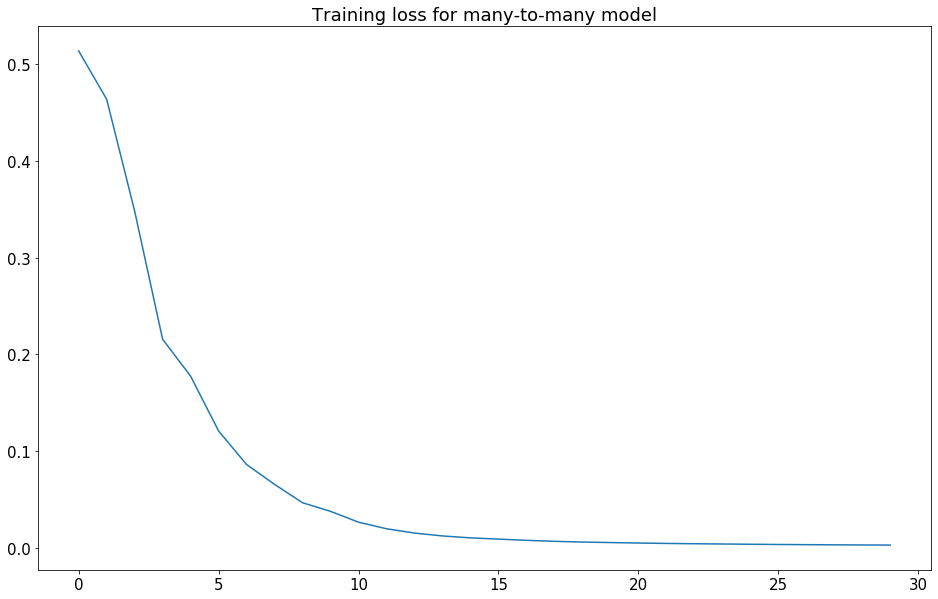

In [19]:
plt.figure()
plt.plot(tr_loss_hist)
plt.title('Training loss for many-to-many model')
plt.show()

## Summary

Through this post, we tried to understand the basic concept of many-to-many RNN model, and how it can used for POS tagging. The main difference from previous ones is the output node is more than 2, not one, and measuring the sequence loss. We simply implement the many-to-many model, and it shows good performance as we expect. (Actually, we need to use validation data, not training data itself for performance measurement.)

{{ 'Reference from stanford CS231n lecture note' | fndetail: 1}}
{{ 'Bring the definition from [wikipedia](https://en.wikipedia.org/wiki/Part_of_speech)' | fndetail: 2}}